In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
def preprocess_nfl_data(file_path):
    # Load the dataset into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Define the regular expression pattern to match the characters at the end of the names
    end_characters_pattern = r'(\+|\*|\+\*|\*\+)$'

    # Remove the characters from the end of the 'Player' column
    df['Player'] = df['Player'].str.replace(end_characters_pattern, '', regex=True)

    # Remove all unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Preprocess the column names to remove the extra tabs
    df.columns = df.columns.str.replace(r'\t', '')

    # Replace NaN and null values with 0
    df.fillna(0, inplace=True)

    # Convert 'Year' column to integers (with error handling)
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    # List of columns to convert to float (excluding 'Player', 'Tm', and 'FantPos_Games')
    columns_to_convert = [col for col in df.columns if col not in ['Player', 'Tm', 'FantPos_Games']]

    # Convert the selected columns to float
    df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

    # Calculate 'pass_accuracy' column
    df['pass_accuracy'] = df['Cmp_Passing'] / df['Att_Passing']

    return df

In [5]:
# Define a function to calculate the Player Success Score using weights
def calculate_player_success(row, weights):
    return sum(pd.to_numeric(row[attr], errors='coerce') * weight for attr, weight in weights.items())

In [6]:
# Define a function to get top players for a given position and year
def get_top_players(df, position, year, weights):
    # Filter the data for the specified position and year
    position_year_df = df[(df['FantPos_Games'] == position) & (df['Year'] == year)]

    # Calculate the Player Success Score using the weights for each player
    position_year_df['PlayerSuccessScore'] = position_year_df.apply(lambda row: calculate_player_success(row, weights), axis=1)

    # Sort the data based on the Player Success Score for the position and year
    position_year_df = position_year_df.sort_values(by='PlayerSuccessScore', ascending=False)

    # Select the top 30 players for the position and year
    top_players = position_year_df.head(30)

    return top_players

In [7]:
def filter_and_group_top_players(df, position_weights):
    # Initialize an empty list to store the top players for each position and year
    top_players_by_year = []

    # Iterate over each year from 2010 to 2019
    for year in range(2010, 2020):
        # Iterate over each position and get the top players for each position and year
        for position, weights in position_weights.items():
            top_players_by_year.append(get_top_players(df, position, year, weights))

    # Concatenate the results into a single DataFrame
    top_players_df = pd.concat(top_players_by_year)

    # Filter and group the top players to get the top player for each position
    top_player_each_position_df = top_players_df.drop_duplicates(subset='Player', keep='first')
    top_player_each_position = top_player_each_position_df['FantPos_Games'].value_counts()

    return top_player_each_position_df, top_player_each_position

In [8]:
def filter_and_group_top_players_test(df, position_weights):
    # Initialize an empty list to store the top players for each position and year
    top_players_by_year = []

    # Iterate over each year from 2020 to 2021
    for year in range(2020, 2022):
        # Iterate over each position and get the top players for each position and year
        for position, weights in position_weights.items():
            top_players_by_year.append(get_top_players(df, position, year, weights))

    # Concatenate the results into a single DataFrame
    top_players_df = pd.concat(top_players_by_year)

    # Filter and group the top players to get the top player for each position
    top_player_each_position_df = top_players_df.drop_duplicates(subset='Player', keep='first')
    top_player_each_position = top_player_each_position_df['FantPos_Games'].value_counts()

    return top_player_each_position_df, top_player_each_position

In [9]:
def process_and_merge_data(cleaned_data_file_path, top_player_each_position_df, position_weights):
    # Load the cleaned data into a DataFrame
    combined_df = pd.read_csv(cleaned_data_file_path)

    # Sort the DataFrame by 'Player' and 'year' in descending order
    combined_df_sorted = combined_df.sort_values(by=['Player', 'year'], ascending=[True, False])

    # Drop duplicates based on 'Player', keeping the last occurrence (latest data)
    combined_df_latest = combined_df_sorted.drop_duplicates(subset='Player', keep='last')

    # Perform the left join based on the "Player" column in top_player_each_position_df and "Player" column in combined_df
    unique_players_df = top_player_each_position_df.merge(combined_df_latest, on='Player', how='left')
    
    # List of columns to replace null, NaN, and 0 values with median
    columns_to_replace = ['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle', 'Height']

    # Replace null, NaN, and 0 values with median for each column
    for col in columns_to_replace:
        median_value = unique_players_df[col].median()
        unique_players_df[col] = unique_players_df[col].replace({0.0: median_value, pd.NA: median_value})
        unique_players_df[col].fillna(median_value, inplace=True)
    
    unique_players_df['Drafted'].fillna(1.0, inplace = True)
    
    player_count_each_position =  unique_players_df['FantPos_Games'].value_counts()
    

    return combined_df_latest, unique_players_df, player_count_each_position


In [10]:
# Calculate Q1, Q3, IQR, minimum, maximum, median, standard deviation,lower bound, and upper bound for each column
def calculate_stats(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    minimum = column.min()
    maximum = column.max()
    median = column.median()
    std_dev = column.std()
    lower_bound = median - 2 * std_dev
    upper_bound = median + 2 * std_dev
    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower bound': lower_bound,
        'upper bound': upper_bound,
        'minimum': minimum,
        'maximum': maximum,
        'median': median,
        'Standard Deviation': std_dev
    }

In [11]:
# Statsicts for each position
def calculate_stats_for_position(position_df):
    stats_dict = {}
    for col_name in position_df.columns:
        stats_dict[col_name] = calculate_stats(position_df[col_name])
    return pd.DataFrame.from_dict(stats_dict, orient='index').round(3)

In [12]:
# position wise stats
def process_positions(unique_players_df, positions):
    position_stats = {}
    for position in positions:
        position_df = unique_players_df[unique_players_df['FantPos_Games'] == position]
        position_df = position_df[['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle', 'Height']]
        position_stats[position] = calculate_stats_for_position(position_df)
    return position_stats

In [13]:
def filter_players_based_on_conditions(position_df, metric_conditions):
    check_df = pd.DataFrame()

    for col in position_df.columns:
        condition_func = metric_conditions.get(col, lambda x: 1)  # Default condition is always True if not provided
        check_df[col] = position_df[col].apply(lambda x: 1 if condition_func(x) else 0)

    return check_df

In [14]:
def calculate_accuracy(check_df, position_name):
    total_players = len(check_df)
    filtered_players = len(check_df[check_df.all(axis=1)])
    accuracy = (filtered_players / total_players) * 100
    return accuracy

### MAIN

In [15]:
#main items - global things
file_path = '/Users/sehwag/Library/CloudStorage/OneDrive-UniversityCollegeDublin/Microsoft Teams Chat Files/NFL_data.csv'
preprocessed_df = preprocess_nfl_data(file_path)

# Define a list of positions and their respective weights for each statistic
position_weights = {
    'QB': {'Yds_Passing': 1,
        'TD_Passing': 2,
        'Int_Passing': 2,
           'pass_accuracy': 1,
           'Cmp_Passing': 1
    },
    'RB': {'Yds_Rushing': 1,
        'TD_Rushing': 2,
        'Rec_Receiving': 1,
        'Yds_Receiving': 1,
        'TD_Receiving': 1.25,
        'Y/A_Rushing':  1,
           'Tgt_Receiving': 1,
           'Y/R_Receiving': 1
    },
    'WR': {'Rec_Receiving': 2,
        'Yds_Receiving': 1,
        'TD_Receiving': 1,
           'Tgt_Receiving': 2,
           'Y/R_Receiving': 1
    },
    'TE': {'Rec_Receiving': 2,
        'Yds_Receiving': 1,
        'TD_Receiving': 1,
           'Tgt_Receiving': 2,
           'Y/R_Receiving': 1
    }
}


top_player_each_position_df, top_player_each_position = filter_and_group_top_players(preprocessed_df, position_weights)

print("Top player for each position and year:")
print(top_player_each_position_df)

print("\nCount of top players for each position:")
print(top_player_each_position)

cleaned_data_file_path = '/Users/sehwag/Library/CloudStorage/OneDrive-UniversityCollegeDublin/Microsoft Teams Chat Files/cleaned_data.csv'
combined_df_latest, final_result_df, player_count_each_position = process_and_merge_data(cleaned_data_file_path, top_player_each_position_df, position_weights)

print("\n physical attributes:")
print(combined_df_latest)

print("\nTop players with their physical attributes:")
print(final_result_df)

print("\nCount of top players for each position with their physical attributes:")
print(player_count_each_position)

QB_box_plot = final_result_df[final_result_df['FantPos_Games'] == 'QB']

positions = ['QB', 'RB', 'WR', 'TE']
position_stats = process_positions(final_result_df, positions)

# Now you have four separate dictionaries for each position's statistics
qb_dict = position_stats['QB']
qb_dict = qb_dict.transpose()

rb_dict = position_stats['RB']
rb_dict = rb_dict.transpose()

wr_dict = position_stats['WR']
wr_dict = wr_dict.transpose()

te_dict = position_stats['TE']
te_dict = te_dict.transpose()

print("\nStats for QB:")
print(qb_dict)

print("\nStats for RB:")
print(rb_dict)

print("\nStats for WR:")
print(wr_dict)

print("\nStats for TE:")
print(te_dict)
    
top_player_test_df, top_player_test_position = filter_and_group_top_players_test(preprocessed_df, position_weights)

combined_df_latest, test_df, player_count_each_position_test = process_and_merge_data(cleaned_data_file_path, top_player_test_df, position_weights)

print("\nTop players with their physical attributes in test data:")
print(test_df)

print("\nCount of top players for each position with their physical attributes in test data:")
print(player_count_each_position_test)



# Define the metric conditions for each position
metric_conditions = {
    'QB': {
        'Wt': lambda x: qb_dict['Wt']['lower bound'] <= x <= qb_dict['Wt']['upper bound'],
        'Height': lambda x: qb_dict['Height']['lower bound'] <= x <= qb_dict['Height']['upper bound'],
        '40yd': lambda x: x <= qb_dict['40yd']['upper bound'],
        'Vertical': lambda x: x >= qb_dict['Vertical']['lower bound'],
        'Bench': lambda x: x >= qb_dict['Bench']['lower bound'],
        'Broad Jump': lambda x: x >= qb_dict['Broad Jump']['lower bound'],
        '3Cone': lambda x: x <= qb_dict['3Cone']['upper bound'],
        'Shuttle': lambda x: x <= qb_dict['Shuttle']['upper bound'],
    },
    'RB': {
        # Define RB metric conditions here
        'Wt': lambda x: rb_dict['Wt']['lower bound'] <= x <= rb_dict['Wt']['upper bound'],
        'Height': lambda x: rb_dict['Height']['lower bound'] <= x <= rb_dict['Height']['upper bound'],
        '40yd': lambda x: x <= rb_dict['40yd']['upper bound'],
        'Vertical': lambda x: x >= rb_dict['Vertical']['lower bound'],
        'Bench': lambda x: x >= rb_dict['Bench']['lower bound'],
        'Broad Jump': lambda x: x >= rb_dict['Broad Jump']['lower bound'],
        '3Cone': lambda x: x <= rb_dict['3Cone']['upper bound'],
        'Shuttle': lambda x: x <= rb_dict['Shuttle']['upper bound'],
    },
    'WR': {
        # Define WR metric conditions here
        'Wt': lambda x: wr_dict['Wt']['lower bound'] <= x <= wr_dict['Wt']['upper bound'],
        'Height': lambda x: wr_dict['Height']['lower bound'] <= x <= wr_dict['Height']['upper bound'],
        '40yd': lambda x: x <= wr_dict['40yd']['upper bound'],
        'Vertical': lambda x: x >= wr_dict['Vertical']['lower bound'],
        'Bench': lambda x: x >= wr_dict['Bench']['lower bound'],
        'Broad Jump': lambda x: x >= wr_dict['Broad Jump']['lower bound'],
        '3Cone': lambda x: x <= wr_dict['3Cone']['upper bound'],
        'Shuttle': lambda x: x <= wr_dict['Shuttle']['upper bound'],
    },
    'TE': {
        # Define TE metric conditions here
        'Wt': lambda x: te_dict['Wt']['lower bound'] <= x <= te_dict['Wt']['upper bound'],
        'Height': lambda x: te_dict['Height']['lower bound'] <= x <= te_dict['Height']['upper bound'],
        '40yd': lambda x: x <= te_dict['40yd']['upper bound'],
        'Vertical': lambda x: x >= te_dict['Vertical']['lower bound'],
        'Bench': lambda x: x >= te_dict['Bench']['lower bound'],
        'Broad Jump': lambda x: x >= te_dict['Broad Jump']['lower bound'],
        '3Cone': lambda x: x <= te_dict['3Cone']['upper bound'],
        'Shuttle': lambda x: x <= te_dict['Shuttle']['upper bound'],
    }
}

positions = ['QB', 'RB', 'WR', 'TE']
accuracy_results = []

for position in positions:
    position_df = test_df[test_df['FantPos_Games'] == position]
    position_df = position_df[['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle', 'Height']]
    check_df = filter_players_based_on_conditions(position_df, metric_conditions[position])
    filtered_df = check_df[check_df.all(axis=1)]

    total_players = len(check_df)
    filtered_players = len(filtered_df)
    accuracy = calculate_accuracy(check_df, position)

    accuracy_results.append((position, filtered_players, total_players, accuracy))

# Calculate overall accuracy
overall_accuracy = sum(accuracy for _, _, _, accuracy in accuracy_results) / len(accuracy_results)

# Print accuracy results in a table
print(tabulate(accuracy_results, headers=['Position', 'Matching Players', 'Total Players', 'Accuracy (%)']))

# Print overall accuracy
print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")


/var/folders/f5/pbssjctj60b48x7hf3g_k3th0000gn/T/ipykernel_44626/895257201.py:3: DtypeWarning: Columns (34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/f5/pbssjctj60b48x7hf3g_k3th0000gn/T/ipykernel_44626/895257201.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r'\t', '')
/var/folders/f5/pbssjctj60b48x7hf3g_k3th0000gn/T/ipykernel_44626/1208865850.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_year_df['PlayerSuccessScore'] = position_year_df.apply(lambda row: calculate_player

Top player for each position and year:
                Player   Tm FantPos_Games  Age_Games  G_Games  GS_Games  \
5805    Peyton Manning  IND            QB       34.0     16.0      16.0   
5817        Drew Brees  NOR            QB       31.0     16.0      16.0   
5808     Philip Rivers  SDG            QB       29.0     16.0      16.0   
5833       Matt Schaub  HOU            QB       29.0     16.0      16.0   
5855       Eli Manning  NYG            QB       29.0     16.0      16.0   
...                ...  ...           ...        ...      ...       ...   
11279      Jonnu Smith  TEN            TE       24.0     16.0      14.0   
11329   T.J. Hockenson  DET            TE       22.0     12.0       7.0   
11316  Jacob Hollister  SEA            TE       26.0     11.0       3.0   
11320      Dawson Knox  BUF            TE       23.0     15.0      11.0   
11264     Darren Fells  HOU            TE       33.0     16.0      14.0   

       Cmp_Passing  Att_Passing  Yds_Passing  TD_Passing  ..

/var/folders/f5/pbssjctj60b48x7hf3g_k3th0000gn/T/ipykernel_44626/1208865850.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_year_df['PlayerSuccessScore'] = position_year_df.apply(lambda row: calculate_player_success(row, weights), axis=1)
/var/folders/f5/pbssjctj60b48x7hf3g_k3th0000gn/T/ipykernel_44626/1208865850.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_year_df['PlayerSuccessScore'] = position_year_df.apply(lambda row: calculate_player_success(row, weights), axis=1)
/var/fol

### OBJECTIVE 4

In [16]:
combined_df_latest

,Player,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,year,Height,Drafted
2381,A'Shawn Robinson,DT,Alabama,307,5.20,26.0,22,106,7.80,4.74,01/01/16,76,1
2955,A.C. Leonard,TE,Tennessee State,252,4.50,34.0,20,128,0.00,4.36,01/01/14,74,0
2844,A.D. Denham,TE,Kansas,235,4.69,32.5,0,0,0.00,4.36,01/01/14,76,0
1165,A.J. Brown,WR,Mississippi,226,4.49,36.5,19,120,0.00,4.36,01/01/19,72,1
2494,A.J. Cann,OG,South Carolina,313,5.47,0.0,26,0,0.00,4.36,01/01/15,75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4554,Ziggy Hood,DT,Missouri,300,4.83,33.0,34,108,7.50,4.55,01/01/09,75,1
147,Zion Johnson,OG,Boston Col.,312,5.18,32.0,32,112,7.38,4.46,01/01/22,75,1
4286,Zoltan Mesko,P,Michigan,240,4.79,0.0,16,0,0.00,4.36,01/01/10,76,1
162,Zonovan Knight,RB,North Carolina St.,209,4.58,31.0,0,114,0.00,4.36,01/01/22,71,0


In [17]:
objective4 = combined_df_latest[combined_df_latest['year'] == '01/01/22']
objective4

,Player,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,year,Height,Drafted
121,Aaron Hansford,LB,Texas A&M,239,0.00,0.0,24,0,0.00,4.36,01/01/22,74,0
173,Abraham Lucas,OT,Washington St.,315,4.92,27.0,24,107,7.25,4.40,01/01/22,78,1
251,Abram Smith,RB,Baylor,213,0.00,0.0,0,0,0.00,4.36,01/01/22,72,0
103,Ahmad Gardner,CB,Cincinnati,190,4.41,0.0,0,0,0.00,4.36,01/01/22,75,1
135,Aidan Hutchinson,DE,Michigan,260,4.74,36.0,0,117,6.73,4.15,01/01/22,79,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,Zakoby McClain,LB,Auburn,228,4.69,33.0,0,117,0.00,4.36,01/01/22,71,0
302,Zamir White,RB,Georgia,214,4.40,33.5,0,128,0.00,4.36,01/01/22,72,1
147,Zion Johnson,OG,Boston Col.,312,5.18,32.0,32,112,7.38,4.46,01/01/22,75,1
162,Zonovan Knight,RB,North Carolina St.,209,4.58,31.0,0,114,0.00,4.36,01/01/22,71,0


In [18]:
combine_player_position = objective4['Pos'].value_counts()

In [19]:
combine_player_position

WR      39
CB      38
RB      36
LB      31
OT      24
OG      24
S       23
DT      22
TE      20
EDGE    17
QB      15
DE      12
C       10
P        5
K        3
LS       1
Name: Pos, dtype: int64

In [20]:
# Function to club positions
def club_positions(pos):
    if pos in ['QB']:
        return 'QB'
    elif pos in ['RB']:
        return 'RB'
    elif pos in ['TE', 'OT', 'OG', 'C', 'LS']:
        return 'TE'
    else:
        return 'WR'

In [21]:
# Apply the club_positions function to the 'Pos' column to create a new column 'Clubbed_Position'
objective4['Position'] = objective4['Pos'].apply(club_positions)

# Set the index as the row number
# objective4.set_index(inplace=True)
# Display the new DataFrame
objective4



/var/folders/f5/pbssjctj60b48x7hf3g_k3th0000gn/T/ipykernel_44626/1556747801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objective4['Position'] = objective4['Pos'].apply(club_positions)


,Player,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,year,Height,Drafted,Position
121,Aaron Hansford,LB,Texas A&M,239,0.00,0.0,24,0,0.00,4.36,01/01/22,74,0,WR
173,Abraham Lucas,OT,Washington St.,315,4.92,27.0,24,107,7.25,4.40,01/01/22,78,1,TE
251,Abram Smith,RB,Baylor,213,0.00,0.0,0,0,0.00,4.36,01/01/22,72,0,RB
103,Ahmad Gardner,CB,Cincinnati,190,4.41,0.0,0,0,0.00,4.36,01/01/22,75,1,WR
135,Aidan Hutchinson,DE,Michigan,260,4.74,36.0,0,117,6.73,4.15,01/01/22,79,1,WR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,Zakoby McClain,LB,Auburn,228,4.69,33.0,0,117,0.00,4.36,01/01/22,71,0,WR
302,Zamir White,RB,Georgia,214,4.40,33.5,0,128,0.00,4.36,01/01/22,72,1,RB
147,Zion Johnson,OG,Boston Col.,312,5.18,32.0,32,112,7.38,4.46,01/01/22,75,1,TE
162,Zonovan Knight,RB,North Carolina St.,209,4.58,31.0,0,114,0.00,4.36,01/01/22,71,0,RB


In [22]:
check_df_top = filter_players_based_on_conditions(objective4, metric_conditions['RB'])
filtered_df_top = check_df_top[check_df_top.drop('Bench', axis=1).all(axis=1)]
filtered_df_top = filtered_df_top.drop('Bench', axis=1)
filtered_df_top

,Player,Pos,School,Wt,40yd,Vertical,Broad Jump,3Cone,Shuttle,year,Height,Drafted,Position
90,1,1,1,1,1,1,1,1,1,1,1,1,1
266,1,1,1,1,1,1,1,1,1,1,1,1,1
256,1,1,1,1,1,1,1,1,1,1,1,1,1
116,1,1,1,1,1,1,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,1,1,1,1,1,1,1,1,1,1,1,1,1
183,1,1,1,1,1,1,1,1,1,1,1,1,1
302,1,1,1,1,1,1,1,1,1,1,1,1,1
162,1,1,1,1,1,1,1,1,1,1,1,1,1


In [23]:
merged_df_top = objective4.merge(filtered_df_top, left_index=True, right_index=True, how='inner')
merged_df_top

,Player_x,Pos_x,School_x,Wt_x,40yd_x,Vertical_x,Bench,Broad Jump_x,3Cone_x,Shuttle_x,...,Wt_y,40yd_y,Vertical_y,Broad Jump_y,3Cone_y,Shuttle_y,year_y,Height_y,Drafted_y,Position_y
90,Akayleb Evans,CB,Missouri,197,4.46,36.0,0,129,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
266,Alontae Taylor,CB,Tennessee,199,4.36,34.5,0,128,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
256,Baylon Spector,LB,Clemson,233,4.60,36.0,0,122,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
116,Breece Hall,RB,Iowa St.,217,4.39,40.0,0,126,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
10,Brian Asamoah,LB,Oklahoma,226,4.56,36.5,0,124,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,Verone McKinley III,S,Oregon,198,0.00,35.0,16,120,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
183,Zakoby McClain,LB,Auburn,228,4.69,33.0,0,117,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
302,Zamir White,RB,Georgia,214,4.40,33.5,0,128,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
162,Zonovan Knight,RB,North Carolina St.,209,4.58,31.0,0,114,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1


In [24]:
merged_df_top_1 = merged_df_top[merged_df_top['Drafted_x']==1.0]
merged_df_top_1 

,Player_x,Pos_x,School_x,Wt_x,40yd_x,Vertical_x,Bench,Broad Jump_x,3Cone_x,Shuttle_x,...,Wt_y,40yd_y,Vertical_y,Broad Jump_y,3Cone_y,Shuttle_y,year_y,Height_y,Drafted_y,Position_y
90,Akayleb Evans,CB,Missouri,197,4.46,36.0,0,129,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
266,Alontae Taylor,CB,Tennessee,199,4.36,34.5,0,128,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
256,Baylon Spector,LB,Clemson,233,4.60,36.0,0,122,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
116,Breece Hall,RB,Iowa St.,217,4.39,40.0,0,126,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
10,Brian Asamoah,LB,Oklahoma,226,4.56,36.5,0,124,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
233,Brian Robinson,RB,Alabama,225,4.53,30.0,0,119,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
43,Chance Campbell,LB,Mississippi,232,4.57,39.5,0,127,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
278,Channing Tindall,LB,Georgia,230,4.47,42.0,0,129,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
122,Christian Harris,LB,Alabama,226,4.44,34.5,0,132,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1
141,D'Marco Jackson,LB,Appalachian St.,233,4.55,33.0,0,125,0.00,4.36,...,1,1,1,1,1,1,1,1,1,1


In [25]:
selected_columns = ['Player_x', 'Position_x']
Potential_Players = merged_df_top[selected_columns]
# Create separate DataFrames for each position
position_tables = {}
for position in Potential_Players['Position_x'].unique():
    position_tables[position] = Potential_Players[Potential_Players['Position_x'] == position][['Player_x']]

# Print the separate DataFrames
for position, table in position_tables.items():
    print(f"Players for Position {position}:")
    print(table)
    print()

Players for Position WR:
                 Player_x
90          Akayleb Evans
266        Alontae Taylor
256        Baylon Spector
10          Brian Asamoah
43        Chance Campbell
278      Channing Tindall
122      Christian Harris
141       D'Marco Jackson
20            Dane Belton
17             David Bell
77      Dontario Drummond
93          Erik Ezukanma
111  Isaiah Graham-Mobley
314              JT Woods
245          Jack Sanborn
28         Jaquan Brisker
74            JoJo Domann
274        Juanyeh Thomas
153          Kerby Joseph
154      Kevin Austin Jr.
201           Leon O'Neal
49             Lewis Cine
237     Malcolm Rodriguez
16         Markquese Bell
8             Matt Araiza
315            Mike Woods
248          Nephi Sewell
61             Nick Cross
196            Skyy Moore
21         Terrel Bernard
102           Ty Fryfogle
6          Tycen Anderson
152           Velus Jones
138   Verone McKinley III
183        Zakoby McClain
184         Zyon McCollum

Players for 

In [26]:
QB_box_plot = final_result_df[final_result_df['FantPos_Games'] == 'QB']
RB_box_plot = final_result_df[final_result_df['FantPos_Games'] == 'RB']
WR_box_plot = final_result_df[final_result_df['FantPos_Games'] == 'WR']
TE_box_plot = final_result_df[final_result_df['FantPos_Games'] == 'TE']

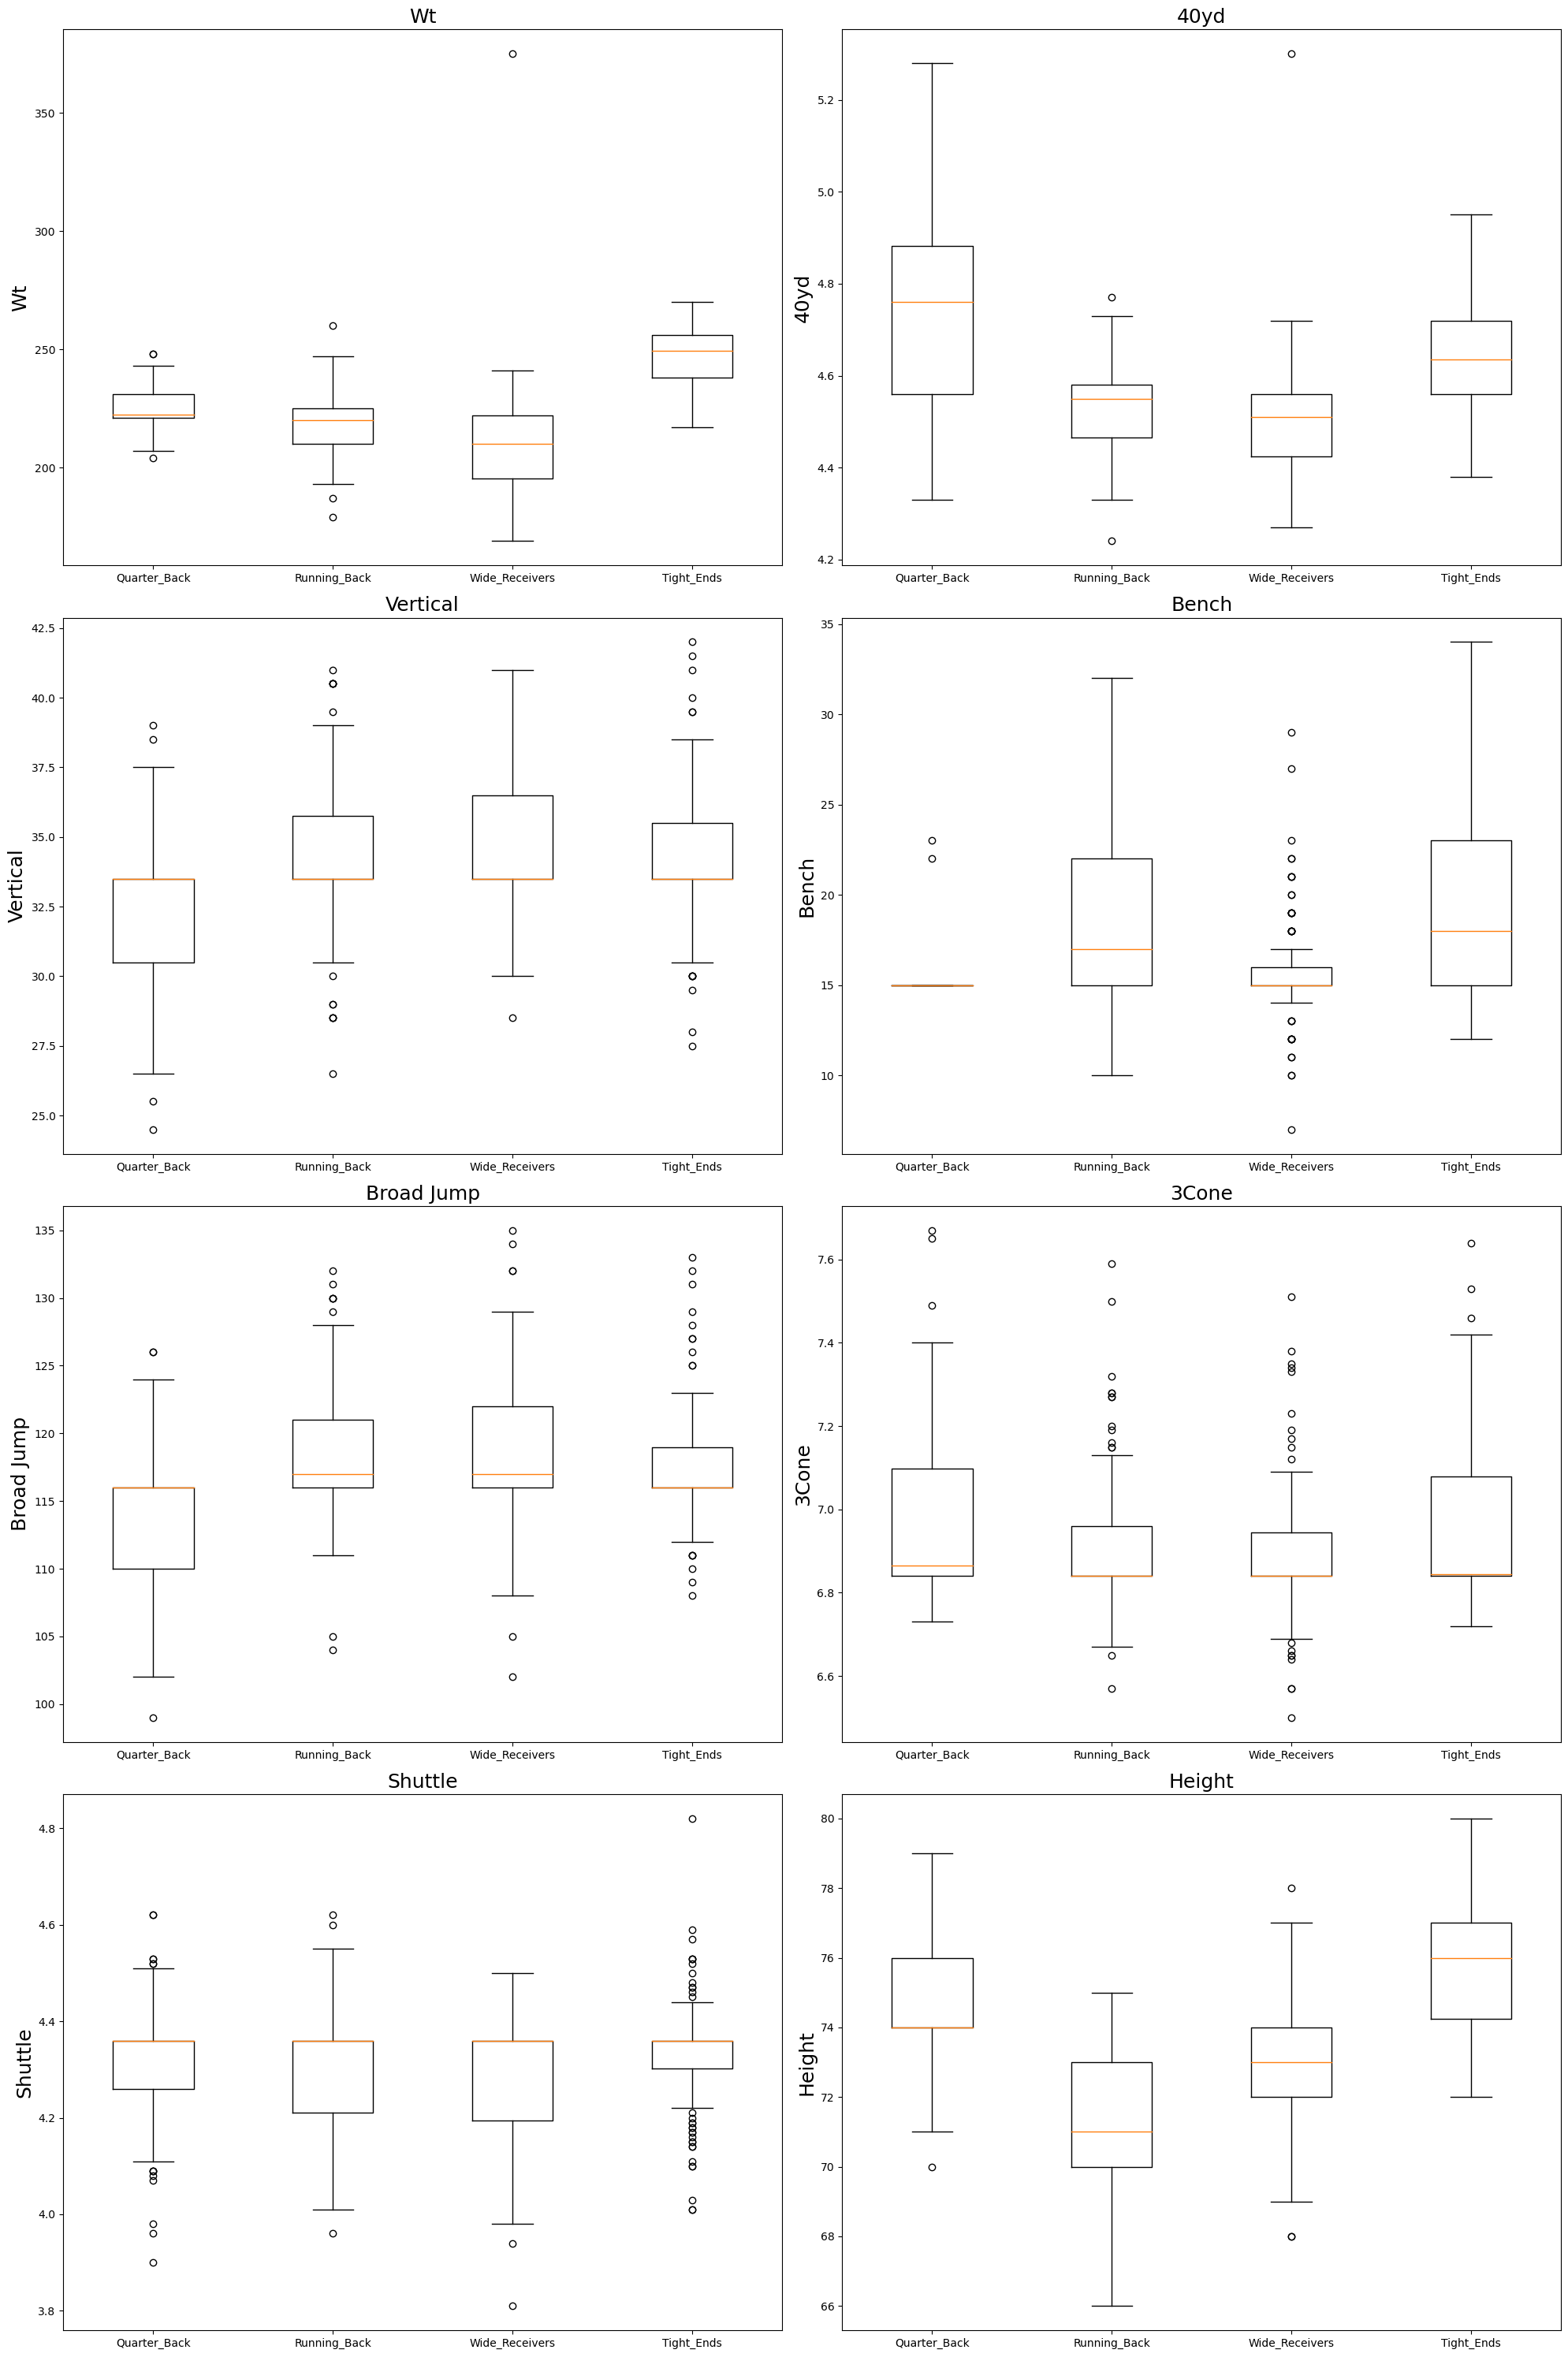

In [35]:
# List of common columns you want to create box plots for
common_columns = ['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle', 'Height']

# List of DataFrames
dataframes = [QB_box_plot, RB_box_plot, WR_box_plot, TE_box_plot]  

# Determine the number of rows and columns for subplots
num_rows = 4
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust the figure size as needed

# Loop over each common column and create a box plot for each DataFrame
for i, column in enumerate(common_columns):
    row = i // num_cols
    col = i % num_cols
    
    data = [df[column] for df in dataframes]
    
    axes[row, col].boxplot(data, labels=['Quarter_Back', 'Running_Back', 'Wide_Receivers', 'Tight_Ends'])
    axes[row, col].set_title(f"{column}", fontsize=18 )
    axes[row, col].set_ylabel(column, fontsize=18 )

    
# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

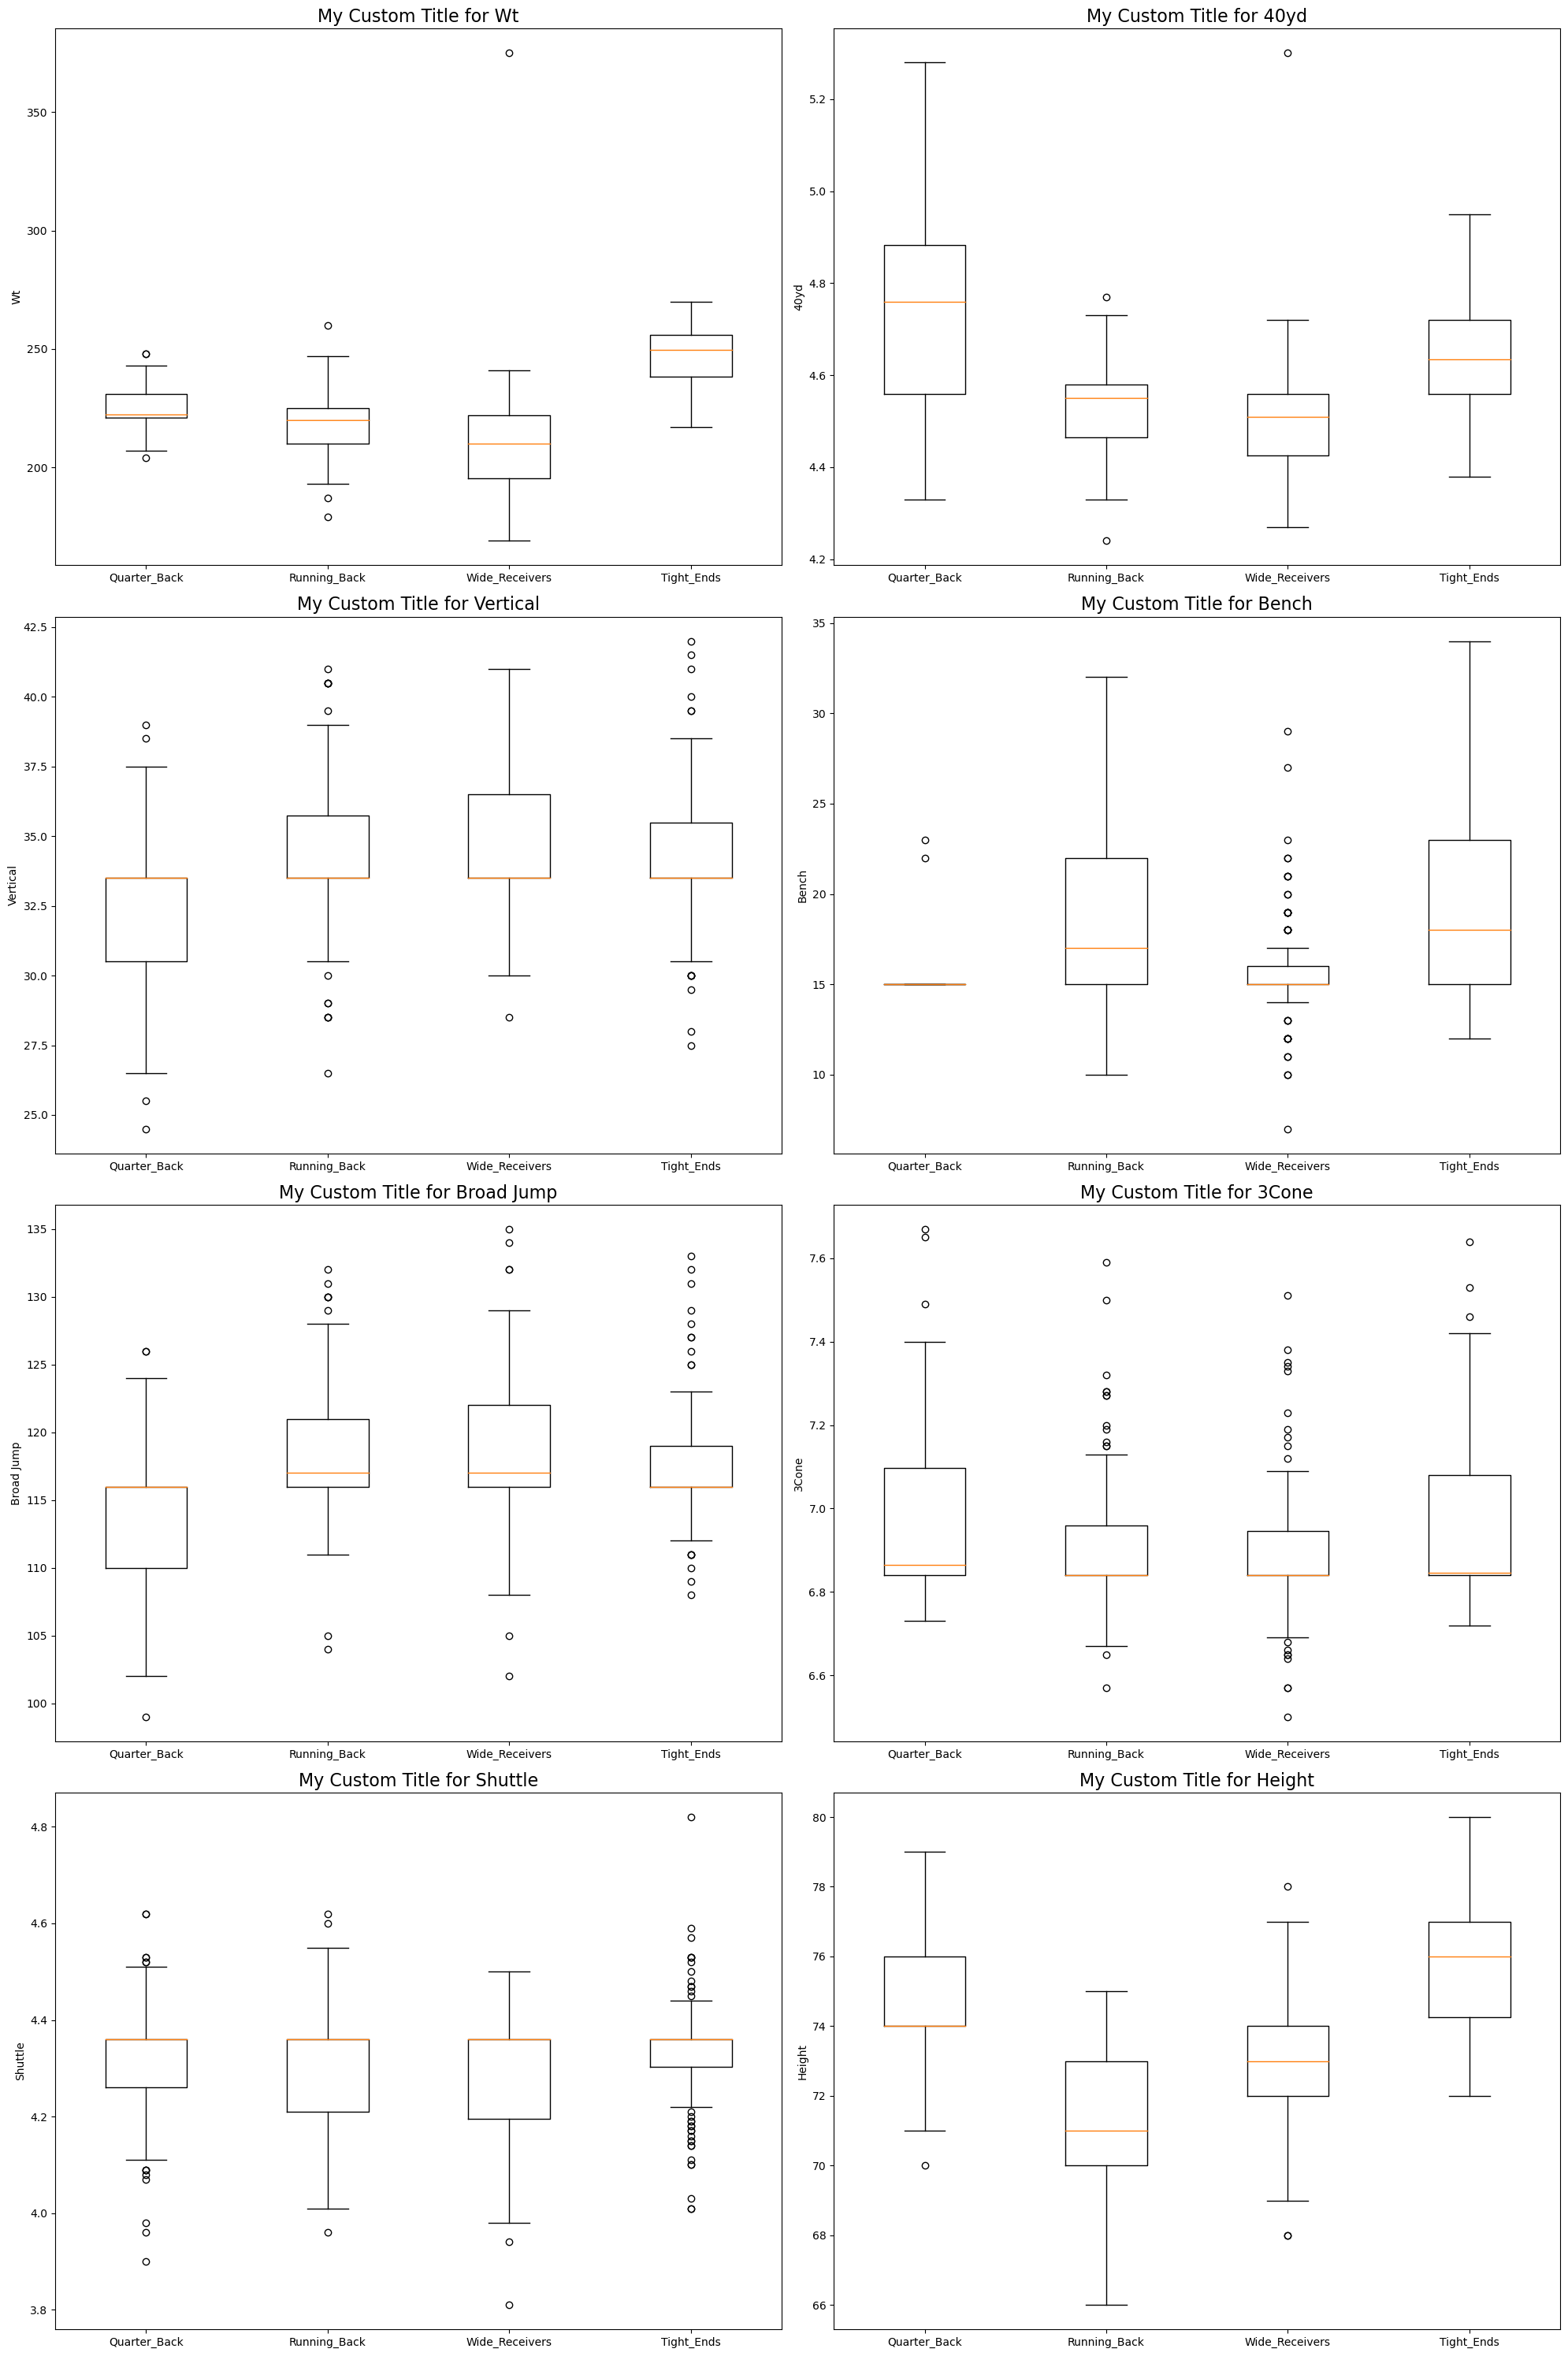

In [30]:
# List of common columns you want to create box plots for
common_columns = ['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle', 'Height']

# List of DataFrames
dataframes = [QB_box_plot, RB_box_plot, WR_box_plot, TE_box_plot] 

# Determine the number of rows and columns for subplots
num_rows = 4
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust the figure size as needed

# Loop over each common column and create a box plot for each DataFrame
for i, column in enumerate(common_columns):
    row = i // num_cols
    col = i % num_cols
    
    data = [df[column] for df in dataframes]
    
    box = axes[row, col].boxplot(data, labels=['Quarter_Back', 'Running_Back', 'Wide_Receivers', 'Tight_Ends'])
    axes[row, col].set_ylabel(column)
    
    # Customize the title
    axes[row, col].set_title(f"My Custom Title for {column}", fontsize=16)  # Adjust fontsize as needed
    
    # Increase the title size
    title = box['medians'][0]
    title.set_markerfacecolor('red')  # Customize title color
    
# Adjust layout and display the subplots
plt.tight_layout()
plt.show()
